In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical   
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D , Dense, Flatten, Dropout, BatchNormalization

I have used CIFAR-100 dataset. From which I have extracted 10 classes which are seen in day-to-day life. 

In [2]:
#Loading data
(trainX, trainy), (testX, testy) = cifar100.load_data(label_mode='fine')

In [3]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo)
    return dict

In [4]:
#Using meta file from https://www.cs.toronto.edu/~kriz/cifar.html site to get label names.
labels=unpickle('meta')

In [5]:
labels_dict={i:labels['fine_label_names'][i] for i in range(len(labels['fine_label_names']))}

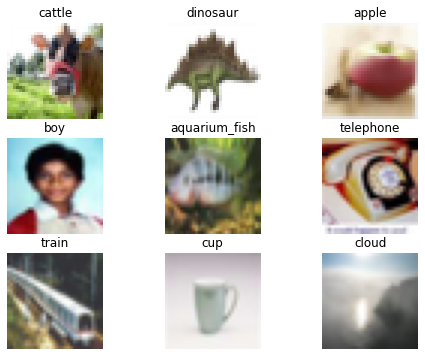

In [6]:
#sanity check for images and their labels
fig,axs=plt.subplots(3,3,figsize=(8,6))
axs = axs.ravel()

for i in range(9):
  axs[i].set_title(labels_dict[trainy[i][0]])
  axs[i].imshow(trainX[i])
  axs[i].axis('off')

plt.show()

In [7]:
labels['coarse_label_names']

['aquatic_mammals',
 'fish',
 'flowers',
 'food_containers',
 'fruit_and_vegetables',
 'household_electrical_devices',
 'household_furniture',
 'insects',
 'large_carnivores',
 'large_man-made_outdoor_things',
 'large_natural_outdoor_scenes',
 'large_omnivores_and_herbivores',
 'medium_mammals',
 'non-insect_invertebrates',
 'people',
 'reptiles',
 'small_mammals',
 'trees',
 'vehicles_1',
 'vehicles_2']

I considered food_containers and household_furniture super classes for the given task.

They consist bottles, bowls, cans, cups, plates and bed, chair, couch, table,wardrobe classes respectively.



In [8]:
num_label = []
classes= ['bottle', 'bowl', 'can', 'cup', 'plate', 'bed', 'chair', 'couch', 'table', 'wardrobe']
ivd = {v: k for k, v in labels_dict.items()}
for i in classes:
  num_label.append(ivd[i])
print(num_label)

[9, 10, 16, 28, 61, 5, 20, 25, 84, 94]


In [9]:
newlabel_dict={num_label[i]:i for i in range(len(num_label))}
ivd_newlabel_dict= {v: k for k, v in newlabel_dict.items()}

In [10]:
ivd_newlabel_dict

{0: 9, 1: 10, 2: 16, 3: 28, 4: 61, 5: 5, 6: 20, 7: 25, 8: 84, 9: 94}

In [11]:
#Function for creating custom dataset
def custom_dataset(trainx,trainy,testx,testy,num_labels):
  trainX.astype('float32')
  trainy.astype('float32')
  new_trainx=[]
  new_trainy=[]
  new_testx=[]
  new_testy=[]
  for i in range(len(trainy)):
    if trainy[i][0] in num_labels:
      new_trainx.append(trainx[i]/255.0)
      new_trainy.append(newlabel_dict[trainy[i][0]])
  for i in range(len(testy)):
    if testy[i][0] in num_labels:
      new_testx.append(testx[i]/255.0)
      new_testy.append(newlabel_dict[testy[i][0]])
  return new_trainx,new_trainy,new_testx,new_testy

In [12]:
train_images, train_labels,test_images, test_labels=custom_dataset(trainX,trainy,testX,testy,num_label)

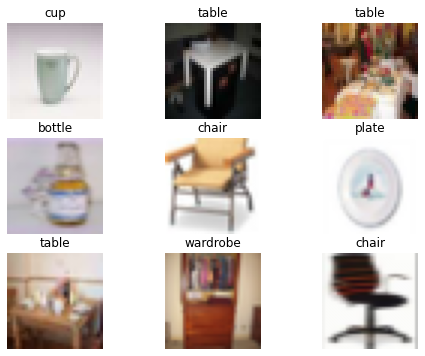

In [13]:
#sanity check for images and their labels in custom dataset
fig,axs=plt.subplots(3,3,figsize=(8,6))
axs = axs.ravel()
for i in range(9):
  axs[i].set_title(labels_dict[ivd_newlabel_dict[train_labels[i]]])
  axs[i].imshow(train_images[i])
  axs[i].axis('off')
plt.show()

In [14]:
train_images = np.array(train_images)
test_images = np.array(test_images)
train_labels = to_categorical(train_labels, num_classes=10)
test_labels = to_categorical(test_labels, num_classes=10)

In [15]:
len(train_images),len(train_labels),len(test_images),len(test_labels)

(5000, 5000, 1000, 1000)

In [16]:
def create_model():
  model = Sequential()
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.5))
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.5))
  model.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dropout(0.25))
  model.add(Dense(10, activation='softmax'))
  return model

In [17]:
model=create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        18464     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        9

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('model-{epoch:03d}-{accuracy:03f}-{val_accuracy:03f}.h5', verbose=1, monitor='val_accuracy',save_best_only=True, mode='auto')  
model.compile(optimizer='Adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'],)

history = model.fit(train_images, train_labels, epochs=100,callbacks=[checkpoint],
                    validation_data=(test_images, test_labels))

Epoch 1/100
153/157 [============================>.] - ETA: 0s - loss: 0.8567 - accuracy: 0.6946
Epoch 00001: val_accuracy improved from -inf to 0.68500, saving model to model-001-0.692800-0.685000.h5
157/157 [==============================] - 1s 8ms/step - loss: 0.8632 - accuracy: 0.6928 - val_loss: 0.9444 - val_accuracy: 0.6850
Epoch 2/100
153/157 [============================>.] - ETA: 0s - loss: 0.8337 - accuracy: 0.6985
Epoch 00002: val_accuracy did not improve from 0.68500
157/157 [==============================] - 1s 7ms/step - loss: 0.8313 - accuracy: 0.6994 - val_loss: 0.9633 - val_accuracy: 0.6770
Epoch 3/100
153/157 [============================>.] - ETA: 0s - loss: 0.8131 - accuracy: 0.7108
Epoch 00003: val_accuracy did not improve from 0.68500
157/157 [==============================] - 1s 7ms/step - loss: 0.8104 - accuracy: 0.7114 - val_loss: 1.0127 - val_accuracy: 0.6840
Epoch 4/100
153/157 [============================>.] - ETA: 0s - loss: 0.8065 - accuracy: 0.7138
Epoch

KeyboardInterrupt: 

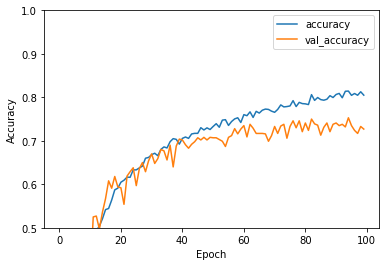

In [20]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend()

In [22]:
model=create_model()
model.load_weights('model-095-0.814400-0.753000.h5')
model.compile(optimizer='Adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'],)
loss, acc = model.evaluate(np.array(test_images),  test_labels)
print("Best model, Val_accuracy: {:5.2f}%".format(100 * acc))

32/32 [==============================] - 0s 3ms/step - loss: 0.8256 - accuracy: 0.7530
Best model, Val_accuracy: 75.30%


In [23]:
def predfn(i):
  plt.figure(figsize=(4,2))
  plt.imshow(test_images[i])
  print('Actual - ',labels_dict[ivd_newlabel_dict[np.argmax(test_labels[i])]])
  print('Predicted - ',labels_dict[ivd_newlabel_dict[np.argmax(model.predict(test_images[i].reshape(1,32,32,3)))]])

Actual -  bottle
Predicted -  bottle


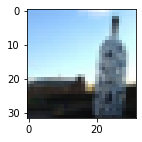

In [24]:
predfn(50)

Actual -  table
Predicted -  cup


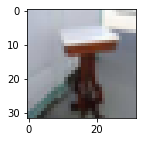

In [25]:
predfn(101)

Actual -  chair
Predicted -  chair


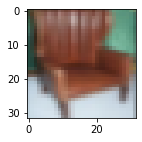

In [26]:
predfn(10)

Actual -  bowl
Predicted -  plate


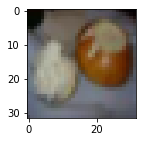

In [27]:
predfn(197)